# Trying Regression Algorithm using various methods

This Notebook epxeriments with various Regression Model implementations.

The goal is to test:
1. Use dataset as-is
2. Apply scaling to all rows: The error-results for 1 and 2 should be same.
3. Remove correlated columns > 0.5
4. With each column removed. 

The data-set will be divided into 
1. Training set (80%) - 20%
2. Train using all and still test (over fitting)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unified_regression import LinearRegression as MyLinearRegression
from unified_regression import LogisticRegression as MyLogisticRegression
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.pipeline import Pipeline
import pickle
import tabulate


In [2]:
# Helps to print the output to the console of the import statements
import sys
stdout = sys.stdout
np.set_printoptions(suppress=True)

# DataSet


Create following data:
1. X, Y: Whole dataset
2. X_S, Y_X: Scaled (standard) datasets
3. X_train, X_test, Y_train, Y_test original non-scaled data
4. X_train_S, Y_Train_S, Y_train_S, Y_test_S scaled test and Train datasets



In [3]:
# Import dataset for regression
ca_housing = fetch_california_housing()
X = ca_housing.data
Y = ca_housing.target.reshape(-1,1)
print(f"X.shape, Y.shape: {X.shape}, {Y.shape}")
print(f"X.dtype, Y.dtype: {X.dtype}, {Y.dtype}")

X.shape, Y.shape: (20640, 8), (20640, 1)
X.dtype, Y.dtype: float64, float64


In [4]:
# Create X_Train and X_Test for all X, X_S, Y, Y_S
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"X_train.shape, X_test.shape: {X_train.shape}, {X_test.shape}")
print(f"y_train.shape, y_test.shape: {y_train.shape}, {y_test.shape}")


X_train.shape, X_test.shape: (16512, 8), (4128, 8)
y_train.shape, y_test.shape: (16512, 1), (4128, 1)


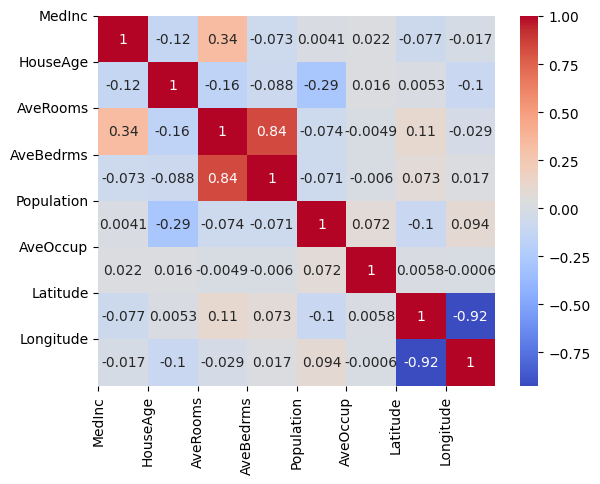

In [5]:
# Get the correlation matrix of the features
corr_matrix = np.corrcoef(X_train.T)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# Show column names in the heatmap, at center of row
plt.xticks(range(X_train.shape[1]), ca_housing.feature_names, rotation=90)
plt.yticks(range(X_train.shape[1]), ca_housing.feature_names, rotation=0)
plt.show()

## Delete correlated features
These will be used train and test the algorithm. To get an idea of model performance after removing the correlated features.

In [6]:
def identify_correlated_features(corr_matrix, feature_names):
    # Print columns names that are highly correlated with the target)
    delete_candidate_features = []
    for i, col in enumerate(feature_names):
        correlated_features = abs(corr_matrix[i,i+1:]) > 0.5
        if correlated_features.sum() >= 1:
            delete_candidate_features.append((i, col))
    return delete_candidate_features

In [7]:
np_feature_names = np.array(ca_housing.feature_names)
delete_candidate_features = identify_correlated_features(corr_matrix, np_feature_names)
print(f"All features: {np_feature_names}")
print(f"delete_candidate_features: {delete_candidate_features}")
delete_candidate_features_indices = [i for i, _ in delete_candidate_features]
np_feature_names = np.delete(np_feature_names, delete_candidate_features_indices)
print(f"Updated feature names: {np_feature_names}")
# Remove "AveBedrms", "Longitude" from the X_train and X_test
X_reduced = np.delete(X, delete_candidate_features_indices, axis=1)
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)
# Print the shape of the reduced X_train and X_test
print(f"X_reduced_train.shape, X_reduced_test.shape: {X_reduced_train.shape}, {X_reduced_test.shape}")
print(f"y_reduced_train.shape, y_reduced_test.shape: {y_reduced_train.shape}, {y_reduced_test.shape}")

All features: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude']
delete_candidate_features: [(2, np.str_('AveRooms')), (6, np.str_('Latitude'))]
Updated feature names: ['MedInc' 'HouseAge' 'AveBedrms' 'Population' 'AveOccup' 'Longitude']
X_reduced_train.shape, X_reduced_test.shape: (16512, 6), (4128, 6)
y_reduced_train.shape, y_reduced_test.shape: (16512, 1), (4128, 1)


# Custom Gradient Descent
The basic algorithm implemented:
<pre>
Input:
    X := m x n matrix (m: features, n:training samples)
    y := m x 1 vector (targets)

Initialize:
    W := (n+1) x 1 params (bias+weights), vector of zeros (or small random numbers)

Preprocess:
    X:= Add a column of 1s to X for the bias term

Loop (for num_iters):
    predictions := X ⋅ W
    errors := predictions - y
    gradients := (1/m) ⋅ X.T ⋅ errors
    delta_W = alpha ⋅ gradients
    if norm(delta_W) < tolerance:
        done
    W := W - delta_W
</pre>

It is implemented two ways using:
1. NumPy: vectors [](./gradient_descent_np.py)
2. PyTorch to take advantage of Mac Performance Shaders "MPS".

The PyTorch version took significantly longer. Have not investigated the reason yet.

In [8]:
def print_prediction_errors(y_pred, y_true):
    delta = y_pred - y_true
    rmse = np.sqrt(np.mean(delta ** 2))
    mae = np.mean(np.abs(delta))
    r2 = 1 - np.sum(delta ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    print(f"rmse: {rmse}, mae: {mae}, r2: {r2}")
    return rmse, mae, r2

In [9]:
all_errors = []

## Option 1:  Custom Model without scaling
The model will not converge.

In [10]:
# Now train the model on non-scaled data. It does not converge.
my_model = MyLinearRegression(
    alpha=0.001, max_iter=50_000_000, tol=1e-6, max_tol=1e7)
my_model.fit(X_train, y_train)
print(
    f"time_taken: {my_model.training_time},"
    f"iter_count: {my_model.training_iter},"
    f"tolerance: {my_model.training_tolerance},"
    f"loss: {my_model.training_loss}"
)
print(f"params: {my_model.coef_.reshape(1, -1)}, intercept: {my_model.intercept_}")

X: (16512, 8), y: (16512,)
No convergence: 32634730.0 [[   -13995.696    -54400.797   -359521.22     -74115.695    -15006.113
  -32585950.       -52643.383   -496422.25    1671541.5  ]]
time_taken: 0.0008703339990461245,iter_count: 2,tolerance: 32634730.0,loss: 2295449088.0
params: [[   -4.1971054   -16.31087    -107.84441     -22.22659      -4.50038
  -9763.464       -15.781561   -148.87265     501.27258  ]], intercept: -4.197105407714844


## Option 2: Custom Model with scaling

Use X_Train and Y_Train and measure the error

In [11]:
# Now train the model on scaled data
my_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MyLinearRegression(alpha=0.01, max_iter=10_000_000, tol=1e-6, max_tol=1e7))
]).fit(X_train, y_train)

X: (16512, 8), y: (16512,)


In [12]:
pipeline_model = my_pipeline.named_steps['model']
print(
    f"time_taken: {pipeline_model.training_time:,.2f}s, "
    f"iter_count: {pipeline_model.training_iter:,}, "
    f"tolerance: {pipeline_model.training_tolerance:}, "
    f"loss: {pipeline_model.training_loss:,.2f}"
)

time_taken: 0.51s, iter_count: 11,695, tolerance: 9.997415872931015e-07, loss: 92.48


In [13]:
my_predictions = my_pipeline.predict(X_train)
rmse, mae, r2 = print_prediction_errors(my_predictions, y_train)
all_errors.append(
    {'model': 'MyLinearRegression', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "train"})
test_predictions = my_pipeline.predict(X_test)
rmse, mae, r2 = print_prediction_errors(test_predictions, y_test)
all_errors.append(
    {'model': 'MyLinearRegression', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "test"})


rmse: 0.719675851080912, mae: 0.5286001401002178, r2: 0.6125510379648367
rmse: 0.745616517759427, mae: 0.5331817060634771, r2: 0.5757477239647759


In [14]:
my_predictions[:5], y_train[:5]

(array([[1.9369601],
        [2.489269 ],
        [2.645836 ],
        [1.5656092],
        [1.6134267]], dtype=float32),
 array([[1.03 ],
        [3.821],
        [1.726],
        [0.934],
        [0.965]]))

## Option 3: Sklearn Model with scaling

Use X_Train and Y_Train and measure the error

In [15]:
sklearn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
]).fit(X_train, y_train)

In [16]:
# Print pipeline and model parameters, coefficients and intercept
print(f"pipeline: {sklearn_pipeline.named_steps}")

pipeline: {'scaler': StandardScaler(), 'model': LinearRegression()}


In [17]:
sk_p_t1 = sklearn_pipeline.predict(X_train)
rmse, mae, r2 = print_prediction_errors(sk_p_t1, y_train)
all_errors.append(
    {'model': 'LinearRegression pipeline', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "train"})
sk_p_t2 = sklearn_pipeline.predict(X_test)
rmse, mae, r2 = print_prediction_errors(sk_p_t2, y_test)
all_errors.append(
    {'model': 'LinearRegression pipeline', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "test"})

rmse: 0.7196757085831575, mae: 0.5286283596581934, r2: 0.6125511913966952
rmse: 0.7455813830127762, mae: 0.5332001304956565, r2: 0.575787706032451


## Option 4: Sklearn Model without scaling

Use X_Train and Y_Train and measure the error

In [18]:
# Train using standard Linear Regression on sklearn
sklearn_model = LinearRegression()
result =sklearn_model.fit(X_train, y_train)
sk_t1 = sklearn_model.predict(X_train)
rmse, mae, r2 = print_prediction_errors(sk_t1, y_train)
all_errors.append(
    {'model': 'LinearRegression', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "train"})
sk_t2 = sklearn_model.predict(X_test)
rmse, mae, r2 = print_prediction_errors(sk_t2, y_test)
all_errors.append(
    {'model': 'LinearRegression', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "test"})

rmse: 0.7196757085831574, mae: 0.5286283596582378, r2: 0.6125511913966952
rmse: 0.7455813830127751, mae: 0.5332001304956981, r2: 0.5757877060324523


## Option 5: Custom Model with Reduced Features

In [19]:
p1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MyLinearRegression(alpha=0.01, max_iter=10_000_000, tol=1e-6, max_tol=1e7))
]).fit(X_reduced_train, y_reduced_train)
p1_t1 = p1.predict(X_reduced_train)
rmse, mae, r2 = print_prediction_errors(p1_t1, y_reduced_train)
all_errors.append(
    {'model': 'MyLinearRegression Reduced', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "train"})
p1_t2 = p1.predict(X_reduced_test)
rmse, mae, r2 = print_prediction_errors(p1_t2, y_reduced_test)
all_errors.append(
    {'model': 'MyLinearRegression Reduced', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "test"})

X: (16512, 6), y: (16512,)
rmse: 0.804231542393371, mae: 0.5999970876099295, r2: 0.5161588002585544
rmse: 0.8126623929263536, mae: 0.6030895435015499, r2: 0.4960198107286027


## Option 6: Linear Regression Scaled with Reduced Featurs

In [20]:
p2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
]).fit(X_reduced_train, y_reduced_train)
p2_t1 = p2.predict(X_reduced_train)
rmse, mae, r2 = print_prediction_errors(p2_t1, y_reduced_train)
all_errors.append(
    {'model': 'LinearRegression Reduced', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "train"})
p2_t2 = p2.predict(X_reduced_test)
rmse, mae, r2 = print_prediction_errors(p2_t2, y_reduced_test)
all_errors.append(
    {'model': 'LinearRegression Reduced', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "test"})

rmse: 0.8042315344635566, mae: 0.5999968489281748, r2: 0.5161588098000129
rmse: 0.8126651254911864, mae: 0.6030888628618839, r2: 0.4960164214715902


## Option 7: Linear Regression with Reduced Features

In [21]:
p3 = LinearRegression().fit(X_reduced_train, y_reduced_train)
p3_t1 = p3.predict(X_reduced_train)
rmse, mae, r2 = print_prediction_errors(p3_t1, y_reduced_train)
all_errors.append(
    {'model': 'LinearRegression Reduced', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "train"})
p3_t2 = p3.predict(X_reduced_test)
rmse, mae, r2 = print_prediction_errors(p3_t2, y_reduced_test)
all_errors.append(
    {'model': 'LinearRegression Reduced', 'rmse': rmse, 'mae': mae, 'r2': r2, "test": "test"})

rmse: 0.8042315344635566, mae: 0.5999968489281753, r2: 0.5161588098000129
rmse: 0.8126651254911865, mae: 0.6030888628618843, r2: 0.4960164214715901


## Print Test Results
Note that the scaled models for MyLinearRegression and Linear regression produce exact identical results. 

The reduced feature set produced worst errors in MyLinearRegression.

In [22]:
print(tabulate.tabulate(all_errors, headers='keys', tablefmt='grid'))

+----------------------------+----------+----------+----------+--------+
| model                      |     rmse |      mae |       r2 | test   |
+============================+==========+==========+==========+========+
| MyLinearRegression         | 0.719676 | 0.5286   | 0.612551 | train  |
+----------------------------+----------+----------+----------+--------+
| MyLinearRegression         | 0.745617 | 0.533182 | 0.575748 | test   |
+----------------------------+----------+----------+----------+--------+
| LinearRegression pipeline  | 0.719676 | 0.528628 | 0.612551 | train  |
+----------------------------+----------+----------+----------+--------+
| LinearRegression pipeline  | 0.745581 | 0.5332   | 0.575788 | test   |
+----------------------------+----------+----------+----------+--------+
| LinearRegression           | 0.719676 | 0.528628 | 0.612551 | train  |
+----------------------------+----------+----------+----------+--------+
| LinearRegression           | 0.745581 | 0.5332   

In [23]:
print("Coefficients All features:")
print(f"[My]: [{pipeline_model.coef_[1:].round(4)}]")
print(
    f"[Pi]: {sklearn_pipeline.named_steps['model'].coef_.round(4)}")
print(f"[SK]: {sklearn_model.coef_.round(4)}")
print("Coefficients Reduced Feature Set:")
print(f"[MR]: [{p1.named_steps['model'].coef_[1:].round(4)}]")
print(f"[PR]: {p2.named_steps['model'].coef_.round(4)}")
print(f"[RR]: {p3.coef_.round(4)}")
print("Intercepts All features:")
print(f"[My]: [{pipeline_model.intercept_:0.4f}]")
print(f"[SK]: {sklearn_pipeline.named_steps['model'].intercept_.round(4)}")
print(f"[SK]: {sklearn_model.intercept_.round(4)}")
print("Intercepts Reduced Feature Set:")
print(f"[MR]: [[{p1.named_steps['model'].intercept_:4f}]]")
print(f"[PR]: [{p2.named_steps['model'].intercept_.round(4)}]")
print(f"[RR]: [{p3.intercept_.round(4)}]")

Coefficients All features:
[My]: [[ 0.8549  0.1227 -0.2953  0.34   -0.0023 -0.0409 -0.8957 -0.8687]]
[Pi]: [[ 0.8544  0.1225 -0.2944  0.3393 -0.0023 -0.0408 -0.8969 -0.8698]]
[SK]: [[ 0.4487  0.0097 -0.1233  0.7831 -0.     -0.0035 -0.4198 -0.4337]]
Coefficients Reduced Feature Set:
[MR]: [[ 0.8293  0.234   0.0244  0.0421 -0.0505 -0.02  ]]
[PR]: [[ 0.8294  0.2341  0.0244  0.0422 -0.0505 -0.02  ]]
[RR]: [[ 0.4355  0.0186  0.0564  0.     -0.0044 -0.01  ]]
Intercepts All features:
[My]: [2.0719]
[SK]: [2.0719]
[SK]: [-37.0233]
Intercepts Reduced Feature Set:
[MR]: [[2.071935]]
[PR]: [[2.0719]]
[RR]: [[-1.4455]]


In [24]:
# Save the model - m_xs
pickle.dump(my_pipeline, open('./data/custom_linear_regression.pkl', 'wb'))

In [25]:
pickle.dump(sklearn_pipeline, open('./data/sklearn_linear_regression.pkl', 'wb'))

In [26]:
my_pipeline.predict(X[:5])

array([[4.1522183],
       [3.9998612],
       [3.6732614],
       [3.2589533],
       [2.4023833]], dtype=float32)